Notebook on time series causality, part 4

INCOMPLETE, NEEDS MORE THOUGHT! SEEMS NOT TO WORK AS INITIALLY PLANNED.

Here we look into what might happen in local projections of dependent variable $Y_{2}$ on independent variable $Y_{1}$ when different lag structure of independent variable is used on RHS of the local projection regression. The result is that it depends on the assumed dynamic causal structure between $Y_{2}$ and $Y_{1}$!

To set up the stage, we simulate data from a know VAR process in two differing cases:

- in case 1, $Y_{1}$ affects $Y_{2}$ negatively on three lags.
- in case 2,  $Y_{1}$ affects $Y_{2}$ positively on first lag and negatively on lags 2 and 3.

Then, from the known VAR we calculate what the impulse reponse of $Y_{2}$ on $Y_{1}$ over 20 period horizon to see what the real (causal) effects are. We compare these to following three $i=1, 2, 3$ (mis-specified) local projections of $Y_{2}$ on past values of $Y_{1}$ and $Y_{2}$:

$$Y_{2,t+2}^{(i)} \sim \tilde{Y}_{1}^{(i)} + Y_{2,t} + Y_{2,t-1} + \epsilon$$

where $\tilde{Y}_{1}^{(i)}$ is a varying set of lags for variable $y_{1}$:
 - $\tilde{Y}_{1}^{(1)} = Y_{1,t}$
 - $\tilde{Y}_{1}^{(2)} = Y_{1,t-1}$
 - $\tilde{Y}_{1}^{(3)} = Y_{1,t} + Y_{1,t-1}$

## Imports

In [112]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [113]:
%%R 
library(dagitty)

In [114]:
#!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py

In [115]:
%load_ext RWinOut

The RWinOut extension is already loaded. To reload it, use:
  %reload_ext RWinOut


In [116]:
def fit_svar_and_irfs(df_in, lags, irf_horizon):
    """
    We 'guess' the correct DGP and fit such model to simulated data.
    
    For structural identification/impulse responses we use Cholesky decomposition such that
    structural shock for $y_{2,t}$, $\omega_{2,t}$, does not contemporaneously affect $y_{1,t}$.
    Does not eally matter in this case, as there's no contemporaneous causal link, and structural
    IRFs will be the same as reduced-form IRFs. 
    """
    # VAR
    model_var = sm.tsa.VAR(df_in.copy())
    res_var = model_var.fit(maxlags=lags)
    irf_var = res_var.irf(irf_horizon)

    # SVAR
    D = np.asarray([
        ["E", 0],
        ["E", "E"],
    ])
    model_svar = sm.tsa.SVAR(df_in.copy(), svar_type='A', A=D)
    res_svar = model_svar.fit(maxlags=lags)
    irf_svar = res_svar.irf(irf_horizon)
    
    fig = irf_svar.plot()
    fig.suptitle(fig._suptitle.get_text(), fontsize=12)
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(top=0.88, wspace=0.3)
    _, _, ax, _ = fig.get_axes()
    for h in range(20):
        print("Estimated effect of y1_t on y2_t+{} is about {:.2f}".format(h, irf_svar.svar_irfs[h, 1, 0]))

def prepare_lp_data(df_in):
    """Prepare data for OLS LP"""
    gg = pd.DataFrame()
    gg["y2"] = df_in["y2"].copy()
    gg["y1"] = df_in["y1"].copy()

    for l in range(15):
        gg["y1_l"+str(l+1)] = df_in["y1"].copy()
        gg["y2_l"+str(l+1)] = df_in["y2"].copy()
    gg = gg.iloc[1:] # remove y_0 row

    for l in range(15):
        gg["y1_l"+str(l+1)] = gg["y1_l"+str(l+1)].shift(l+1)
        gg["y2_l"+str(l+1)] = gg["y2_l"+str(l+1)].shift(l+1)

    gg.dropna(inplace=True)
    return gg

def local_projections(df_in):
    ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y2_l2 + y2_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l3 + y2_l2 + y2_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y1_l3 + y2_l2 + y2_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l2 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y1_l3 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y1_l3 + y1_l4 + y1_l5 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

    ols_res = sm_form.ols(formula="y2 ~ y1_l8 + y1_l9 + y1_l10 + y1_l11 -1", data=df_in.dropna()).fit()
    print(ols_res.summary())
    print("\n"*2)

## Case 1

### DGP

$$
\begin{align*}
Y_{t} & = \beta_{1} Y_{t-1} + \beta_{} Y_{t-2} + \beta_{3} Y_{t-3} + u_{t}
\end{align*}
$$

where

$
\begin{align*}
Y_t = \begin{bmatrix} Y_{1,t} \\ Y_{2,t} \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_1 = \begin{bmatrix} \beta_{1,11} & \beta_{1,12} \\ \beta_{1,21} & \beta_{1,22} \end{bmatrix} = 
\begin{bmatrix} 0.8 & 0 \\ -0.25 & 0.4 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_2 = \begin{bmatrix} \beta_{2, 11} & \beta_{2, 12} \\ \beta_{2, 21} & \beta_{2, 22} \end{bmatrix} = 
\begin{bmatrix} 0.1 & 0 \\ -0.2 & 0.2 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_3 = \begin{bmatrix} \beta_{3, 11} & \beta_{3, 12} \\ \beta_{3, 21} & \beta_{3, 22} \end{bmatrix} =
\begin{bmatrix} 0.05 & 0 \\ -0.1 & 0 \end{bmatrix}
\end{align*}
$.


Shocks are uncorrelated with covariance matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}
$

### Simualate data according to DGP

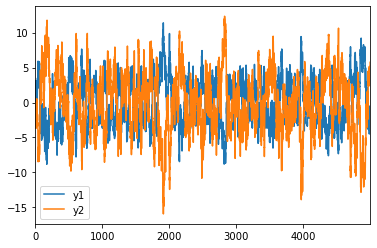

In [117]:
# With this, negativ effects for both contemporaneous and lagged variable
initial_state = [0, 0, 0, 0, 0, 0]
coefs = np.array([
       [0.8, 0, 0.1, 0, 0.05, 0], 
       [-0.25, 0.4, -0.2, 0.2, -0.1, 0],
]).flatten(order="C")
corr = np.array([
    [1, 0],
    [0, 1],
])
stds = [1, 1]
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y1":[np.nan, np.nan, np.nan, np.nan], "y2":[np.nan, np.nan, np.nan, np.nan]}, index=[0, 1, 2, 3])
mod = sm.tsa.VARMAX(endog, order=(3, 0), trend="n")
params = np.concatenate([coefs, np.sqrt(cov[np.tril_indices(cov.shape[0])])], axis=0)
#print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df_case1 = pd.DataFrame(mod.simulate(params=params, nsimulations=5000, initial_state=initial_state))
_ = df_case1.plot()

### Fit a SVAR model to simulated data

Estimated effect of y1_t on y2_t+0 is about -0.02
Estimated effect of y1_t on y2_t+1 is about -0.27
Estimated effect of y1_t on y2_t+2 is about -0.54
Estimated effect of y1_t on y2_t+3 is about -0.72
Estimated effect of y1_t on y2_t+4 is about -0.81
Estimated effect of y1_t on y2_t+5 is about -0.87
Estimated effect of y1_t on y2_t+6 is about -0.90
Estimated effect of y1_t on y2_t+7 is about -0.91
Estimated effect of y1_t on y2_t+8 is about -0.91
Estimated effect of y1_t on y2_t+9 is about -0.89
Estimated effect of y1_t on y2_t+10 is about -0.88
Estimated effect of y1_t on y2_t+11 is about -0.86
Estimated effect of y1_t on y2_t+12 is about -0.83
Estimated effect of y1_t on y2_t+13 is about -0.81
Estimated effect of y1_t on y2_t+14 is about -0.78
Estimated effect of y1_t on y2_t+15 is about -0.76
Estimated effect of y1_t on y2_t+16 is about -0.73
Estimated effect of y1_t on y2_t+17 is about -0.71
Estimated effect of y1_t on y2_t+18 is about -0.68
Estimated effect of y1_t on y2_t+19 is ab

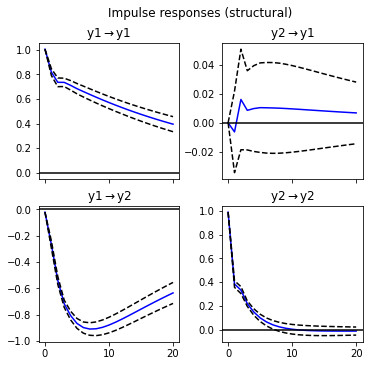

In [118]:
fit_svar_and_irfs(df_case1, lags=3, irf_horizon=20)

### Local projection regressions

In [119]:
df_lp = prepare_lp_data(df_case1)
local_projections(df_lp)

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                          2.325e+04
Date:                Thu, 04 Feb 2021   Prob (F-statistic):                        0.00
Time:                        15:46:17   Log-Likelihood:                         -7593.5
No. Observations:                4984   AIC:                                  1.519e+04
Df Residuals:                    4981   BIC:                                  1.521e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Case 2

### DGP


$$
\begin{align*}
Y_{t} & = \beta_{1} Y_{t-1} + \beta_{} Y_{t-2} + \beta_{3} Y_{t-3} + u_{t}
\end{align*}
$$

where

$
\begin{align*}
Y_t = \begin{bmatrix} Y_{1,t} \\ Y_{2,t} \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_1 = \begin{bmatrix} \beta_{1,11} & \beta_{1,12} \\ \beta_{1,21} & \beta_{1,22} \end{bmatrix} = 
\begin{bmatrix} 0.8 & 0 \\ 0.6 & 0.4 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_2 = \begin{bmatrix} \beta_{2, 11} & \beta_{2, 12} \\ \beta_{2, 21} & \beta_{2, 22} \end{bmatrix} = 
\begin{bmatrix} 0.1 & 0 \\ -0.15 & 0.2 \end{bmatrix}
\end{align*}
$,

$
\begin{align*}
\beta_3 = \begin{bmatrix} \beta_{3, 11} & \beta_{3, 12} \\ \beta_{3, 21} & \beta_{3, 22} \end{bmatrix} =
\begin{bmatrix} 0.05 & 0 \\ -0.7 & 0 \end{bmatrix}
\end{align*}
$.


Shocks are uncorrelated with covariance matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}
$

### Simualate data according to DGP

L1.y1.y1 :0.8
L1.y2.y1 :0.0
L2.y1.y1 :0.1
L2.y2.y1 :0.0
L3.y1.y1 :0.05
L3.y2.y1 :0.0
L1.y1.y2 :0.6
L1.y2.y2 :0.4
L2.y1.y2 :-0.15
L2.y2.y2 :0.2
L3.y1.y2 :-0.7
L3.y2.y2 :0.0
sqrt.var.y1 :1.0
sqrt.cov.y1.y2 :0.0
sqrt.var.y2 :1.0


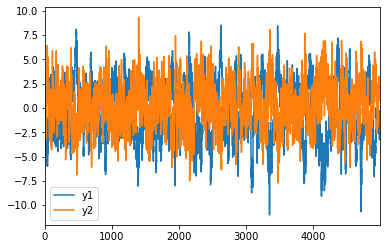

In [120]:
# With this, negativ effects for both contemporaneous and lagged variable
initial_state = [0, 0, 0, 0, 0, 0]
coefs = np.array([
       [0.8, 0, 0.1, 0, 0.05, 0], 
       [0.6, 0.4, -0.15, 0.2, -0.7, 0],
]).flatten(order="C")
corr = np.array([
    [1, 0],
    [0, 1],
])
stds = [1, 1]
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y1":[np.nan, np.nan, np.nan, np.nan], "y2":[np.nan, np.nan, np.nan, np.nan]}, index=[0, 1, 2, 3])
mod = sm.tsa.VARMAX(endog, order=(3, 0), trend="n")
params = np.concatenate([coefs, np.sqrt(cov[np.tril_indices(cov.shape[0])])], axis=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df_case2 = pd.DataFrame(mod.simulate(params=params, nsimulations=5000, initial_state=initial_state))
_ = df_case2.plot()

### Fit a SVAR model to simulated data

Estimated effect of y1_t on y2_t+0 is about 0.01
Estimated effect of y1_t on y2_t+1 is about 0.62
Estimated effect of y1_t on y2_t+2 is about 0.56
Estimated effect of y1_t on y2_t+3 is about -0.03
Estimated effect of y1_t on y2_t+4 is about -0.13
Estimated effect of y1_t on y2_t+5 is about -0.26
Estimated effect of y1_t on y2_t+6 is about -0.34
Estimated effect of y1_t on y2_t+7 is about -0.38
Estimated effect of y1_t on y2_t+8 is about -0.41
Estimated effect of y1_t on y2_t+9 is about -0.42
Estimated effect of y1_t on y2_t+10 is about -0.42
Estimated effect of y1_t on y2_t+11 is about -0.42
Estimated effect of y1_t on y2_t+12 is about -0.41
Estimated effect of y1_t on y2_t+13 is about -0.40
Estimated effect of y1_t on y2_t+14 is about -0.39
Estimated effect of y1_t on y2_t+15 is about -0.38
Estimated effect of y1_t on y2_t+16 is about -0.36
Estimated effect of y1_t on y2_t+17 is about -0.35
Estimated effect of y1_t on y2_t+18 is about -0.34
Estimated effect of y1_t on y2_t+19 is about

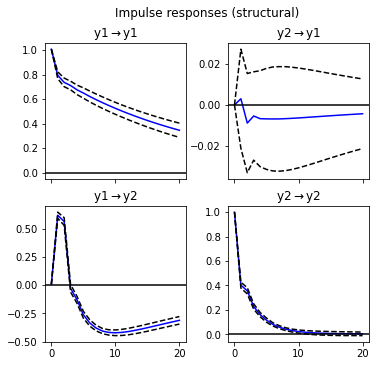

In [121]:
fit_svar_and_irfs(df_case2, lags=3, irf_horizon=20)

### Local projection regressions

In [122]:
df_lp = prepare_lp_data(df_case2)
local_projections(df_lp)

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.572
Model:                            OLS   Adj. R-squared (uncentered):              0.571
Method:                 Least Squares   F-statistic:                              2215.
Date:                Thu, 04 Feb 2021   Prob (F-statistic):                        0.00
Time:                        15:46:18   Log-Likelihood:                         -9222.6
No. Observations:                4984   AIC:                                  1.845e+04
Df Residuals:                    4981   BIC:                                  1.847e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Why does this happen? 

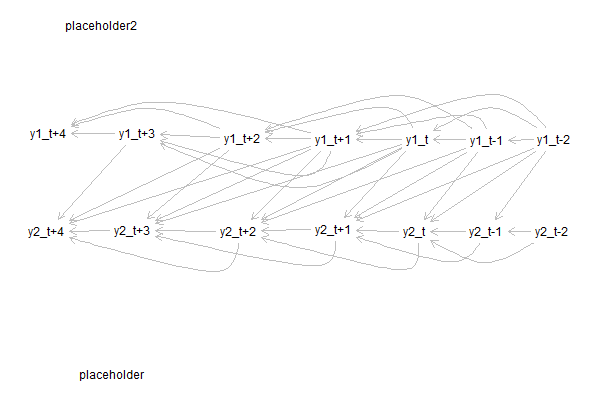

In [123]:
%%R -h 400 -w 600
g = dagitty('dag {
"y1_t+1" [adjusted,pos="-0.131,-0.618"]
"y1_t+2" [exposure,pos="-0.721,-0.627"]
"y1_t+3" [pos="-1.410,-0.664"]
"y1_t+4" [pos="-1.990,-0.659"]
"y1_t-1" [adjusted,pos="0.877,-0.610"]
"y1_t-2" [pos="1.315,-0.614"]
"y2_t+1" [pos="-0.128,0.085"]
"y2_t+2" [pos="-0.746,0.098"]
"y2_t+3" [pos="-1.437,0.094"]
"y2_t+4" [outcome,pos="-2.000,0.098"]
"y2_t-1" [pos="0.871,0.102"]
"y2_t-2" [pos="1.301,0.098"]
placeholder [pos="-1.568,1.213"]
placeholder2 [pos="-1.641,-1.503"]
y1_t [adjusted,pos="0.419,-0.618"]
y2_t [pos="0.403,0.102"]
"y1_t+1" -> "y1_t+2"
"y1_t+1" -> "y1_t+3" [pos="-0.193,-0.219"]
"y1_t+1" -> "y1_t+4" [pos="-1.301,-1.009"]
"y1_t+1" -> "y2_t+2"
"y1_t+1" -> "y2_t+3"
"y1_t+1" -> "y2_t+4"
"y1_t+2" -> "y1_t+3"
"y1_t+2" -> "y1_t+4" [pos="-1.320,-0.931"]
"y1_t+2" -> "y2_t+3"
"y1_t+2" -> "y2_t+4"
"y1_t+3" -> "y1_t+4"
"y1_t+3" -> "y2_t+4"
"y1_t-1" -> "y1_t+1" [pos="0.852,-0.869"]
"y1_t-1" -> "y1_t+2" [pos="0.362,-1.087"]
"y1_t-1" -> "y2_t+1"
"y1_t-1" -> "y2_t+2"
"y1_t-1" -> y1_t
"y1_t-1" -> y2_t
"y1_t-2" -> "y1_t+1" [pos="1.029,-1.100"]
"y1_t-2" -> "y1_t-1"
"y1_t-2" -> "y2_t+1"
"y1_t-2" -> "y2_t-1"
"y1_t-2" -> y1_t [pos="0.909,-0.943"]
"y1_t-2" -> y2_t
"y2_t+1" -> "y2_t+2"
"y2_t+1" -> "y2_t+3" [pos="-0.062,0.472"]
"y2_t+2" -> "y2_t+3"
"y2_t+2" -> "y2_t+4" [pos="-0.743,0.530"]
"y2_t+3" -> "y2_t+4"
"y2_t-1" -> "y2_t+1" [pos="0.727,0.419"]
"y2_t-1" -> y2_t
"y2_t-2" -> "y2_t-1"
"y2_t-2" -> y2_t [pos="0.874,0.423"]
y1_t -> "y1_t+1"
y1_t -> "y1_t+2" [pos="0.319,-0.952"]
y1_t -> "y1_t+3" [pos="-0.321,-0.083"]
y1_t -> "y2_t+1"
y1_t -> "y2_t+2"
y1_t -> "y2_t+3"
y2_t -> "y2_t+1"
y2_t -> "y2_t+2" [pos="0.498,0.509"]
}
')
plot(g)

## What if we take average of $Y_{1}$?